# `Промышленное машинное обучение на Spark`
## `Занятие 05: Feature Engineering`

О чём можно узнать из этого ноутбука:

* Accumulator/Broadcast
* Градиентный спуск
* Винзоризация
* Нормализация данных

In [1]:
! pip3 install pyspark pyarrow

In [2]:
import numpy as np
import random

import pyspark
from pyspark.sql import Window
import pyspark.sql.functions as F
from pyspark.sql import SparkSession

from pyspark import SparkConf, SparkContext

In [3]:
conf = (
    SparkConf()
        .set('spark.ui.port', '4050')
        .setMaster('local[*]')
)
sc = SparkContext(conf=conf)
spark = SparkSession(sc)

### `Spark ML`

**1.1 Что такое Machine Learning в Spark?**

**Apache Spark ML** — это мощная библиотека для машинного обучения, разработанная на основе **DataFrame API**. Она предоставляет инструменты для построения, обучения и развертывания моделей машинного обучения в распределенной среде. Spark ML поддерживает обработку больших объемов данных, что делает его незаменимым инструментом для анализа больших данных (Big Data).

Одним из ключевых преимуществ Spark ML является его способность выполнять **распределенные вычисления**. Это позволяет использовать возможности кластера для параллельной обработки данных и обучения моделей, что значительно ускоряет процесс обработки по сравнению с традиционными подходами.

Ранее в Spark существовала библиотека **MLlib**, которая работала на основе **RDD (Resilient Distributed Dataset)**. Однако RDD имеет ряд ограничений, таких как отсутствие схемы данных и более сложное управление. В связи с этим Spark ML, использующий **DataFrame API**, пришел на смену MLlib и стал основным инструментом машинного обучения в Spark.

**1.2 Почему именно Spark ML?**

Использование **Spark ML** для машинного обучения обусловлено рядом преимуществ, среди которых выделяются:

- **Масштабируемость**: Spark ML эффективно работает в **распределенной среде**, что позволяет обучать модели машинного обучения на **кластерных системах** с большими объемами данных.
- **Поддержка ML-пайплайнов**: Spark ML предоставляет инструменты для **построения конвейеров машинного обучения (ML Pipelines)**, что упрощает процесс подготовки данных, построения моделей и предсказаний.
- **Гибкость и интеграция**: Spark ML легко интегрируется с такими инструментами, как **Pandas**, **SQL**, **Hadoop**, а также с другими технологиями работы с данными. Это делает его удобным инструментом для работы в **разнообразных средах анализа данных**.

**1.3 Основные компоненты Spark M**L

Spark ML предоставляет мощные инструменты для машинного обучения, организованные в несколько ключевых компонентов:

- **DataFrame API**  
  DataFrame API — основа Spark ML, позволяющая работать с данными в **табличном формате**, аналогично Pandas или SQL. DataFrame API предоставляет удобные инструменты для обработки и трансформации данных, что особенно важно для предобработки данных перед обучением моделей.

- **Feature Transformers**  
  В Spark ML предусмотрены **преобразователи признаков (Feature Transformers)**, которые позволяют готовить данные к обучению моделей. Они включают масштабирование числовых признаков, кодирование категориальных переменных, обработку текстовых данных и многое другое.

- **ML Pipelines**  
  Одним из ключевых инструментов Spark ML являются **потоки обработки машинного обучения (ML Pipelines)**. Они позволяют выстраивать **цепочку обработки данных**, объединяя этапы **предобработки данных, обучения модели и предсказаний**. Это значительно упрощает процесс создания моделей машинного обучения.

- **Обучаемые модели**  
  Spark ML поддерживает различные **алгоритмы машинного обучения**, включая линейную регрессию, логистическую регрессию, деревья решений, случайные леса, градиентный бустинг и многие другие. Эти модели работают в распределенной среде и могут обрабатывать **большие объемы данных**.

Использование Spark ML позволяет эффективно строить и развертывать **масштабируемые решения для машинного обучения**, используя преимущества распределенной обработки данных.

### `Общие данные в Spark`

При работе в распределённых окружениях нужно учитывать, что разные воркеры имеют прямой доступ только к своим локальным данным. Как следствие, алгоритмы в таких системах должны учитывать отсутствие общей памяти в целом и проблемы синхронизации между отдельными процессами в частности.

Для решения этой проблемы в Spark предложены два средства: Accumulator и Broadcast.

#### `Accumulator`

Аккумуляторы в Spark представляют из себя общую переменную, которые отдельные воркеры могут обновлять, но не могут считывать (так как значение этой переменной однозначно не определено по причине необходимости дорогостоящей синхронизации между отдельными процессами). Это переменная, значение которой обновляется на воркерах, но читается только на драйвере. Обычно используется для агрегации метрик, таких как подсчет ошибок, логирование или количество обработанных записей.

А таже поддерживают единственную операцию: `+=` (inplace add, `.__iadd__`) — коммутативную, ассоциативную операцию сложения. После того, как воркеры перестанут изменять переменную её значение доступно только на spark-драйвере через атрибут `.value`.

Как работает?
* Воркеры могут увеличивать значение Accumulator, но не могут его читать.
Драйвер читает итоговое значение после выполнения всех задач

Пример использования аккумуляторов — подсчёт общих статистик в процессе вычислений, например, суммарное значение функции потерь (см. пример с GD ниже), общее число слов в датасете и так далее.

In [55]:
# создание такой переменной
# возможно только через SparkContext
acc = sc.accumulator(value=0)
acc

Accumulator<id=56, value=0>

Через атрибут `.value` посмотрим содержимое данной переменной

In [56]:
acc.value

0

In [57]:
# отправляем на каждый из worker-нод данные
rdd = sc.parallelize([1, 2, 3, -4, 5])
# метод .add тоже самое что и +=
rdd.foreach(lambda x: acc.add(x))
acc.value

7

**rdd.foreach(func)** – это действие (action) в PySpark, которое выполняет функцию func для каждого элемента RDD без возврата результата. Используется для побочных эффектов (например, запись в базу, логирование, обновление Accumulator).

Важно:
* foreach выполняется параллельно на воркерах, и результаты нельзя вернуть на драйвер.
* Если нужна обработка с возвратом данных, используй map + collect().

In [58]:
acc.value = 4
acc.value

4

В предыдущем примере для работы с accumulator использовалась анонимная lambda-функция. Но можно пользоваться и обычными именованными функциями с доступом к переменной через объявление её global.

In [59]:
rdd.collect()

[1, 2, 3, -4, 5]

In [60]:
acc_sum = sc.accumulator(0)

def count(x):
    global acc_sum
    acc_sum += x

# теперь вместо lambda-функции указываем имя созданной выше
rdd.foreach(count)
acc_sum.value

7

In [61]:
acc_cnt = sc.accumulator(0)
rdd_02 = sc.parallelize([1, 2, 3, 4, 5, 6, 7, 8])

rdd.foreach(lambda x: acc_cnt.add(1))
rdd_02.foreach(lambda x: acc_cnt.add(1))
acc_cnt.value

13

In [62]:
# Третий пример:

accum_03 = sc.accumulator(0)  # создаем Accumulator с начальным значением 0

def process(x):
    global accum_03
    if x < 0:  # считаем количество отрицательных значений
        accum_03.add(1)

rdd_03 = sc.parallelize([-5, 10, -3, 7, 9, -2])
rdd_03.foreach(process)

print(f"Количество отрицательных значений: {accum_03.value}")

# Важно! Если использовать accumulator внутри трансформаций (map, filter), результат может быть неопределенным, так как Spark может переиспользовать задачи при отказах.

Количество отрицательных значений: 3


В spark можно определять аккумуляторы собственного типа. Для этого необходимо создать класс-наследник класса AccumulatorParam. И реализовать в нём два метода:
- **zero** - "нулевое" значение для созданного нового типа аккумулятора
- **addInPlace** - описание логики сложения

https://spark.apache.org/docs/latest/api/python/reference/api/pyspark.AccumulatorParam.html

In [63]:
from pyspark.accumulators import AccumulatorParam

class VectorAccumulatorParam(AccumulatorParam):
    def zero(self, value):
        "Определяет начальное значение аккумулятора"
        return [0.0] * len(value)

    def addInPlace(self, value_left, value_right):
        "Определяет, как накапливаются значения в аккумуляторе"
        for idx in range(len(value_left)):
             value_left[idx] += value_right[idx]
        return value_left

# Первый аргумент - начальные значения переменной
# Второй аргумент - Объект созданного пользовательского класса аккумулятора
vector_acc = sc.accumulator([1.0, 2.0, 3.0], VectorAccumulatorParam())
vector_acc.value

[1.0, 2.0, 3.0]

Концепция accumulator переменных не ограничивается только математической операцией сложения. Можно реализовывать свою произвольную логику аккумуляции данных.

Например, как ниже реализована аккумуляция строк через механизм их конкатенации.

In [64]:
class StringAccumulator(AccumulatorParam):
    def zero(self, value):
        return value
    def addInPlace(self, s1, s2):
        s1 += s2
        return s1

string_acc = sc.accumulator("", StringAccumulator())
string_acc.value

''

In [65]:
rdd = sc.parallelize(["S", "p", "a", "r", "k"])
rdd.foreach(lambda x: string_acc.add(x))
string_acc.value

'arkSp'

Так как операция конкатенации строк не является коммутативной:  $x + y\neq y + x$, то данный тип аккумулятора может выдавать разные результаты операций при повторных запусках, так как неизвестно какой из woker'ов первым произведёт сложение своей порции данных

#### `Broadcast`

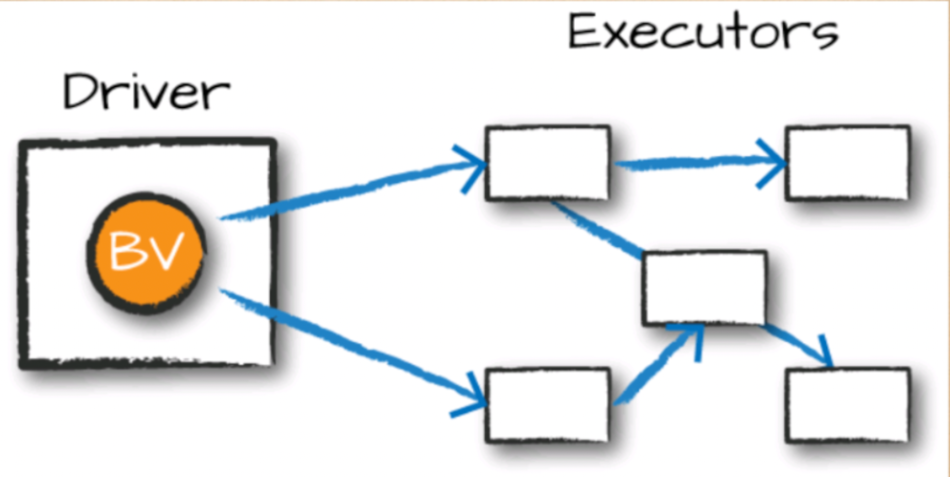

Дополнением к WO (Write Only) переменным (аккумуляторам) являются RO (Read Only) переменные.
В Spark Read-only переменные называюся broadcast-переменными.
Broadcast позволяет отправить на каждый воркер копию данных, которые затем можно использовать локально. Данная копия данных отправляется на каждый из worker-ов в момент её инициализации.

Как работает?
* Драйвер отправляет данные в Broadcast переменную.
* Spark передает данные на все воркеры единожды (через BitTorrent-like протокол), избегая многократных пересылок.

In [15]:
states = {"NY": "New York", "CA": "California", "FL": "Florida"}
broadcast_states = sc.broadcast(states)
broadcast_states.value

{'NY': 'New York', 'CA': 'California', 'FL': 'Florida'}

Если во многих оперциях используются одни и те же значения заранее определённые значения данных, то имеет смысл данные значения поместить в broadcast-переменную и отправить на каждый из worker-нод. Таким образом уменьшив сетевые взаимодействия при обращении к этим данным.

Типичным примером использования broadcast-переменных является применение их для отображения некоторых значений (lookup) как в примере  ниже

In [16]:
data = [
    ("James", "Smith", "USA", "CA"),
    ("Michael", "Rose", "USA", "NY"),
    ("Robert", "Williams", "USA", "CA"),
    ("Maria", "Jones", "USA", "FL")
]

rdd_03 = sc.parallelize(data)

def state_convert(code):
    return broadcast_states.value[code]

result = rdd_03.map(
    lambda x: (x[0], x[1], x[2], state_convert(x[3]))
).collect()
result

[('James', 'Smith', 'USA', 'California'),
 ('Michael', 'Rose', 'USA', 'New York'),
 ('Robert', 'Williams', 'USA', 'California'),
 ('Maria', 'Jones', 'USA', 'Florida')]

Также можно использовать broadcast-переменные в задаче фильтрации данных, если количество данных, по которым нужно производить её невелико.

In [17]:
filtered_states = sc.broadcast(["NY", "FL"])

filtered = rdd_03.filter(
    lambda x: x[3] in filtered_states.value
).collect()
filtered

[('Michael', 'Rose', 'USA', 'NY'), ('Maria', 'Jones', 'USA', 'FL')]

#### `Broadcast JOIN`

И ещё одним распространённым вариантом использования Broadcast является объединение таблиц, одна из которых "маленького" размера. В таком случае может оказаться выгоднее отправить копию меньшей таблицы на каждый воркер и выполнить Join локально, нежели чем выполнять распределённое объединение таблиц через обмен данными по сети.

Нужно учитывать, что пересылка больших таблиц по сети может оказаться дорогостоящей, поэтому выбор между Broadcast Join и "обычным" Join зависит от конкретной конфигурации кластера.

In [76]:
# Можно задать размер DataFrame, при котором join будет автоматически происходить через broadcast этой таблицы
# Размер задаётся в байтах. В данном случае — 100Мб.
spark.conf.set("spark.sql.autoBroadcastJoinThreshold", 104857600)

# Значение -1 отключает Broadcast Join
spark.conf.set("spark.sql.autoBroadcastJoinThreshold", -1)

Скачаем [m5-forecast датасет](https://www.kaggle.com/c/m5-forecasting-accuracy)

In [18]:
import json
import requests
import subprocess
import zipfile

folder_url = 'https://disk.yandex.lt/d/JnDy1h48pJI7IA'
file_url = '/m5-forecating-accuracy.zip'
# запрос ссылки на скачивание
response = requests.get('https://cloud-api.yandex.net/v1/disk/public/resources/download',
                 params={'public_key': folder_url, 'path': file_url})
# 'парсинг' ссылки на скачивание
data_link = response.json()['href']

filename = 'm5-forecating-accuracy.zip'
path = "./m5-forecasting-accuracy"

# запускаем скачивание вызовом команды wget из python
subprocess.run(
    ['wget', '-O', filename, data_link], # команда для исполнения
    stdout=subprocess.DEVNULL, # убираем печать отладочной информации
    stderr=subprocess.STDOUT
)

#распакуем данные по пути path
with zipfile.ZipFile(filename, 'r') as zip_ref:
    zip_ref.extractall(path)

In [19]:
# Зададим пути к файлам из датасета
file_validation = f"{path}/sales_train_validation.csv"
file_evaluation = f"{path}/sales_train_evaluation.csv"
file_prices = f"{path}/sell_prices.csv"
file_calendar = f"{path}/calendar.csv"

file_type = "csv"
infer_schema = "true"
first_row_is_header = "true"
delimiter = ","

df_validation = (
    spark.read.format(file_type)
      .option("inferSchema", infer_schema)
      .option("header", first_row_is_header)
      .option("sep", delimiter)
      .load(file_validation)
)
df_evaluation = (
    spark.read.format(file_type)
      .option("inferSchema", infer_schema)
      .option("header", first_row_is_header)
      .option("sep", delimiter)
      .load(file_evaluation)
)
df_prices = (
    spark.read.format(file_type)
      .option("inferSchema", infer_schema)
      .option("header", first_row_is_header)
      .option("sep", delimiter)
      .load(file_prices)
)
df_calendar = (
    spark.read.format(file_type)
      .option("inferSchema", infer_schema)
      .option("header", first_row_is_header)
      .option("sep", delimiter)
      .load(file_calendar)
)

In [20]:
df_evaluation.limit(5).toPandas()

,id,item_id,dept_id,cat_id,store_id,state_id,d_1,d_2,d_3,d_4,...,d_1932,d_1933,d_1934,d_1935,d_1936,d_1937,d_1938,d_1939,d_1940,d_1941
0,HOBBIES_1_001_CA_1_evaluation,HOBBIES_1_001,HOBBIES_1,HOBBIES,CA_1,CA,0,0,0,0,...,2,4,0,0,0,0,3,3,0,1
1,HOBBIES_1_002_CA_1_evaluation,HOBBIES_1_002,HOBBIES_1,HOBBIES,CA_1,CA,0,0,0,0,...,0,1,2,1,1,0,0,0,0,0
2,HOBBIES_1_003_CA_1_evaluation,HOBBIES_1_003,HOBBIES_1,HOBBIES,CA_1,CA,0,0,0,0,...,1,0,2,0,0,0,2,3,0,1
3,HOBBIES_1_004_CA_1_evaluation,HOBBIES_1_004,HOBBIES_1,HOBBIES,CA_1,CA,0,0,0,0,...,1,1,0,4,0,1,3,0,2,6
4,HOBBIES_1_005_CA_1_evaluation,HOBBIES_1_005,HOBBIES_1,HOBBIES,CA_1,CA,0,0,0,0,...,0,0,0,2,1,0,0,2,1,0


Так как ML-алгоритмы не работают с текстовыми данными, зачастую приходится преобразовывать текстовое предстваление данных в численное. Например, в датафрейме выше такими признаками являются колонки: cat_id, state_id и store_id.

In [21]:
df_evaluation.select(
    df_evaluation.cat_id
).distinct().show()

+---------+
|   cat_id|
+---------+
|    FOODS|
|HOUSEHOLD|
|  HOBBIES|
+---------+



Создадим таблицу-отображение: текст -> число

In [22]:
cat_id_hex = [
    ('FOODS', 0),
    ('HOUSEHOLD', 2),
    ('HOBBIES', 3)
]
small_df = spark.createDataFrame(data=cat_id_hex, schema=['cat_id', 'code'])
small_df.show()

+---------+----+
|   cat_id|code|
+---------+----+
|    FOODS|   0|
|HOUSEHOLD|   2|
|  HOBBIES|   3|
+---------+----+



Для того, чтобы пометить, что некоторый Spark DataFrame должен быть отправлен на все worker-ноды, необходимо вопспользовтаться функцией `broadcast`.

In [23]:
broadcast_join_df = df_evaluation.join(
  F.broadcast(small_df), small_df.cat_id == df_evaluation.cat_id
)
broadcast_join_df.limit(1).toPandas()

,id,item_id,dept_id,cat_id,store_id,state_id,d_1,d_2,d_3,d_4,...,d_1934,d_1935,d_1936,d_1937,d_1938,d_1939,d_1940,d_1941,cat_id,code
0,HOBBIES_1_001_CA_1_evaluation,HOBBIES_1_001,HOBBIES_1,HOBBIES,CA_1,CA,0,0,0,0,...,0,0,0,0,3,3,0,1,HOBBIES,3


Теперь сравним количество операций между join с broadcast-dataframe и просто DataFrame, у которого данные разбиты по worker-нодам

In [24]:
broadcast_join_df.explain()

== Physical Plan ==
AdaptiveSparkPlan isFinalPlan=false
+- BroadcastHashJoin [cat_id#3875], [cat_id#9791], Inner, BuildRight, false
   :- Filter isnotnull(cat_id#3875)
   :  +- FileScan csv [id#3872,item_id#3873,dept_id#3874,cat_id#3875,store_id#3876,state_id#3877,d_1#3878,d_2#3879,d_3#3880,d_4#3881,d_5#3882,d_6#3883,d_7#3884,d_8#3885,d_9#3886,d_10#3887,d_11#3888,d_12#3889,d_13#3890,d_14#3891,d_15#3892,d_16#3893,d_17#3894,d_18#3895,... 1923 more fields] Batched: false, DataFilters: [isnotnull(cat_id#3875)], Format: CSV, Location: InMemoryFileIndex(1 paths)[file:/content/m5-forecasting-accuracy/sales_train_evaluation.csv], PartitionFilters: [], PushedFilters: [IsNotNull(cat_id)], ReadSchema: struct<id:string,item_id:string,dept_id:string,cat_id:string,store_id:string,state_id:string,d_1:...
   +- BroadcastExchange HashedRelationBroadcastMode(List(input[0, string, false]),false), [plan_id=208]
      +- Filter isnotnull(cat_id#9791)
         +- Scan ExistingRDD[cat_id#9791,code#9792L]




In [25]:
join_df = df_evaluation.join(
  small_df, small_df.cat_id == df_evaluation.cat_id
)
join_df.explain()

== Physical Plan ==
AdaptiveSparkPlan isFinalPlan=false
+- SortMergeJoin [cat_id#3875], [cat_id#9791], Inner
   :- Sort [cat_id#3875 ASC NULLS FIRST], false, 0
   :  +- Exchange hashpartitioning(cat_id#3875, 200), ENSURE_REQUIREMENTS, [plan_id=232]
   :     +- Filter isnotnull(cat_id#3875)
   :        +- FileScan csv [id#3872,item_id#3873,dept_id#3874,cat_id#3875,store_id#3876,state_id#3877,d_1#3878,d_2#3879,d_3#3880,d_4#3881,d_5#3882,d_6#3883,d_7#3884,d_8#3885,d_9#3886,d_10#3887,d_11#3888,d_12#3889,d_13#3890,d_14#3891,d_15#3892,d_16#3893,d_17#3894,d_18#3895,... 1923 more fields] Batched: false, DataFilters: [isnotnull(cat_id#3875)], Format: CSV, Location: InMemoryFileIndex(1 paths)[file:/content/m5-forecasting-accuracy/sales_train_evaluation.csv], PartitionFilters: [], PushedFilters: [IsNotNull(cat_id)], ReadSchema: struct<id:string,item_id:string,dept_id:string,cat_id:string,store_id:string,state_id:string,d_1:...
   +- Sort [cat_id#9791 ASC NULLS FIRST], false, 0
      +- Exchange h

Как видно при join'е с broadcast перменной количество необходимых операций меньше

### `Spark RDD Gradient Descent (Градиентный спуск)`

**Gradient Descent (Градиентный спуск) в Spark RDD** – это реализация алгоритма оптимизации методом градиентного спуска в Resilient Distributed Dataset (RDD). Используется для нахождения минимума функции ошибки в задачах машинного обучения, таких как линейная регрессия и логистическая регрессия.

$$
D = \{(x_{i}, y_{i}) | x_{i} \in \mathbb{R}^{d}, y \in \mathbb{R}\}_{1}^{n}
$$
$$
{y}^{pred}_{i} = \langle x, w \rangle + b
$$
$$
L_{i} = \frac{1}{2} ({y}^{pred}_{i} - y_{i})^{2}
$$
$$
\mathfrak{L}(w, b) = \frac{1}{n}\sum\limits_{i=1}^{n} L_{i} \longrightarrow \min_{w, b}
$$

Необходимо найти оптимальные $w \in \mathbb{R}^{d}, b \in \mathbb{R}$

Один из вариантов решения задачи: Градиентный Спуск (GD):

$$
\space   w^{i+1} = w^{i} - \alpha \nabla_{w}\mathfrak{L}
$$
$$
\space  b^{i+1} = b^{i} - \alpha \nabla_{b}\mathfrak{L}
$$

При использовании линейной регрессии делается допущение о распределении данных:
$$
y_{i} \sim \mathcal{N}(\langle x_{i}, w^{*} \rangle, \sigma^{2})
$$

$$\nabla_{w} L = (\frac{\partial L}{\partial w_{1}}, ..., \frac{\partial L}{\partial w_{d}})$$


$$
\nabla_{w} \mathfrak{L} = \frac{1}{2n} \sum\limits_{i=1}^{n} \nabla_{w}({y}^{pred}_{i} - y_{i})({y}^{pred}_{i} - y_{i}) = \frac{1}{n} \sum\limits_{i=1}^{n} ({y}^{pred}_{i} - y_{i}) \nabla_{w}{y}^{pred}_{i} = \{y_{i}^{pred} = \langle x_{i}, w \rangle + b \} = \frac{1}{n} \sum\limits_{i=1}^{n} ({y}^{pred}_{i} - y_{i}) x_{i} = \frac{1}{n} \sum\limits_{i=1}^{n} (\langle x_{i}, w \rangle + b - y_{i}) x_{i}
$$

Как работает Gradient Descent в RDD:
1. Инициализация параметров (весов модели).
2. Разбиение данных на RDD – каждая часть данных обрабатывается на разных воркерах.
3. Выбор случайных начальных параметров.
4. Итерации градиентного спуска:
  1. Вычисление градиента ошибки на каждом батче данных (локально на воркерах).
  2. Агрегация градиентов на драйвере (обычно с помощью reduce или treeReduce).
  3. Обновление весов.
  4. Повторение, пока не достигнута сходимость.
5. Возврат оптимизированных параметров.

Сгенерируем модельные данные, на которых провверим работу алгоритма градиентного спуска

In [66]:
# матрица признаков с 1000 примерами и 11 фичами (10 случайных + 1 bias-столбец)
# np.random.randn(1000, 10) – создает матрицу 1000×10 с нормально распределенными значениями. Это 10 признаков (фичей).
# np.ones((1000, 1)) – добавляет единичный столбец для учета свободного члена (bias) в линейной регрессии.
# np.concatenate(..., axis=1) – объединяет эти два массива по столбцам (по оси 1), создавая матрицу признаков 1000×11.
X = np.concatenate((np.random.randn(1000, 10), np.ones((1000, 1))), axis=1)

# истинный вектор коэффициентов линейной регрессии размером 11×1
# X.shape[1] возвращает 11 (количество признаков).
# np.random.randn(11) – создает случайный вектор весов для модели, включая коэффициент свободного члена.
w_star = np.random.randn(X.shape[1])

# целевая переменная (зависимая переменная) с небольшим шумом.
# X.dot(w_star) – вычисляет линейную комбинацию признаков с истинными весами w_star. Это "чистые" предсказания модели.
# 0.001 * np.random.randn(X.shape[0]) – добавляет малошумовую нормальную случайную ошибку, чтобы y не было полностью детерминированным.
y = X.dot(w_star) + 0.001 * np.random.randn(X.shape[0])

In [67]:
print(type(X))
X

<class 'numpy.ndarray'>


array([[-1.44389972, -0.2772835 , -0.88358354, ..., -0.11939941,
         0.64182666,  1.        ],
       [-1.24260194, -1.57713937,  0.06477175, ...,  1.22025068,
         0.15189195,  1.        ],
       [-1.23859941, -2.52230672, -1.91659886, ...,  1.93918842,
         0.27786455,  1.        ],
       ...,
       [ 1.67926404, -0.7477681 , -1.14107266, ..., -0.99211767,
        -1.35158334,  1.        ],
       [-1.20052339,  1.92361404, -0.65257073, ..., -0.46381379,
        -0.31981132,  1.        ],
       [-0.92502798, -0.93867054, -0.67876816, ..., -0.30011936,
         0.01593207,  1.        ]])

In [68]:
print(type(y))
y

<class 'numpy.ndarray'>


array([-3.05525874e+00,  3.51923094e+00, -1.71620329e+00, -1.42597111e+00,
        6.25349664e+00, -5.08379426e-01,  1.96503137e+00,  2.07917994e-01,
        7.30418591e-01, -2.28771289e+00, -1.59625319e+00,  3.18858440e+00,
        1.02443027e+00,  2.50266177e+00,  5.72402751e+00,  1.72925322e+00,
       -1.12655183e+00,  6.81452971e+00,  6.48178454e+00,  4.90736852e+00,
       -2.41387119e+00, -9.98016643e-01, -3.09012768e+00,  4.38982487e+00,
        2.27631680e+00, -4.06703731e+00,  5.73546986e+00, -2.42308604e+00,
       -1.91167677e+00,  4.47634964e+00,  4.56732731e+00,  4.31210709e-01,
       -2.26080831e+00,  3.21934139e+00,  3.62152082e+00, -1.12095161e+00,
       -7.76312180e-01, -4.94623452e-01, -1.95286972e+00, -3.13525229e+00,
        3.59334053e+00, -2.83892822e+00, -1.65057421e+00, -5.37618353e+00,
        5.10577500e+00,  4.71162437e-01, -1.30558514e+00,  9.13605809e-01,
        3.16816382e+00, -3.82157866e+00,  2.38093252e+00,  2.86096446e+00,
        7.56686903e-01,  

Перепишем с математической формулировки на ...

In [69]:
def gradient_descent(X, y, alpha=0.1, epochs=1):
    # 1. Иницализируем начальные значения весов
    # 2. Итеративно с кол-вом эпох N:
    #     a. Вычисляем ошибку, считаем по ней градиент
    #     b. Обновляем веса
    # 3. На выходе из функции посчитанные веса w

    X_rdd = sc.parallelize(X).cache()
    y_rdd = sc.parallelize(y).cache()

    n = X_rdd.count()
    d = X_rdd.take(1)[0].shape[0]

    # Кэшируем результат вычислений, чтобы не перевычислять его на каждой итерации
    X_y_rdd = X_rdd.zip(y_rdd).cache()
    # инициализируем w нулевым вектором размерности d
    w = np.zeros(d)
    for epoch in range(epochs):
        # на каждой эпохе инициализируем общее значение весов
        # для всех worker-нод и размерность n
        w_br = sc.broadcast(w)
        n_br = sc.broadcast(n)

        total_error = sc.accumulator(0.0)
        def grad_mapper(x_y, total_error):
            delta = (np.sum(x_y[0] * w_br.value) - x_y[1])
            error = (delta ** 2.0) / 2.0
            total_error.add(error / n_br.value)
            return x_y[0] * delta

        grad = X_y_rdd.map(lambda x: grad_mapper(x, total_error=total_error)).sum() / n
        w = w - alpha * grad

        if epoch % 10 == 0:
            print('Epoch: {0:d}, Loss {1:.3f}'.format(epoch, total_error.value / n))
    return w

gradient_descent(X, y, alpha=0.05, epochs=50)

In [70]:
gradient_descent(X, y, alpha=0.05, epochs=50)

Epoch: 0, Loss 0.004
Epoch: 10, Loss 0.001
Epoch: 20, Loss 0.000
Epoch: 30, Loss 0.000
Epoch: 40, Loss 0.000


array([ 0.07329694, -0.91430057,  0.31671297, -1.49177429,  0.82072057,
        0.02312488, -1.57391313,  0.01495652, -0.34242919, -0.5012831 ,
        0.325969  ])

In [71]:
w_star

array([ 0.07190258, -0.96416752,  0.3488342 , -1.6204077 ,  0.87229166,
        0.01612571, -1.68207042,  0.00731009, -0.39385036, -0.51881963,
        0.36912723])

### `Spark Winsorizing`

Винзоризация — это метод предобработки численных данных, при котором значения за пределами заданных квантилей заменяются на значения этих квантилей. Это метод обработки выбросов в данных, при котором экстремальные значения заменяются определенными квантилями (обычно 5% и 95%).

Зачем это нужно?
* Уменьшает влияние выбросов на статистический анализ и машинное обучение.
* Помогает стабилизировать модель, когда небольшие экстремальные значения искажают прогноз.


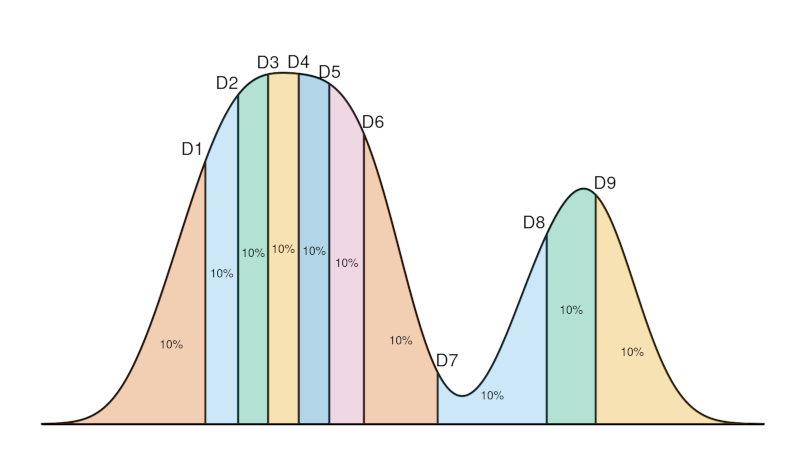

Например, $X = \{100, 6, 52, 26, 8, 81, 52, 15, 2, 74, 93, 82, 36, 22, 74, 90, 97, 50, 4, 40, 1\}$.

Винзоризация для $0.1$ и $0.9$ квантилей выполняется следующим образом:
1. Определяем квантили: $q_{0.1} = 3, q_{0.9} = 93$
2. Заменяем все значения меньше $3$ на $3$ и больше $93$ на $93$:

$$\hat{X} = \{93, 6, 52, 26, 8, 81, 52, 15, 3, 74, 93, 82, 36, 22, 74, 90, 97, 50, 4, 40, 3\}$$

Такая предобработка убирает экстремальные значения и выбросы, что приводит к более надёжному посчёту статистик по выборке (матожидание, дисперисия и так далее).

In [72]:
def winsorizing(
    df: pyspark.sql.dataframe.DataFrame,
    column: str = 'sales',
    lower_percentile: float = 0.1,
    higher_percentile: float = 0.9
) -> pyspark.sql.dataframe.DataFrame:

    wspec = Window().partitionBy()

    lp_column = '_'.join([column, 'lower_percentile'])
    hp_column = '_'.join([column, 'higher_percentile'])
    df = df.withColumns({
        lp_column: F.percentile_approx(F.col(column), lower_percentile).over(wspec),
        hp_column: F.percentile_approx(F.col(column), higher_percentile).over(wspec)
    })

    df = (
        df
            .withColumn(
                '_'.join([column, 'winsorized']),

                F.when(
                    # если значение меньше левой квантили - заменяем
                    F.col(column) < F.col(lp_column),
                    F.col(lp_column)
                ).otherwise(
                    F.when(
                        # если значение больше правой квантили - заменяем на неё
                        F.col(column) > F.col(hp_column),
                        F.col(hp_column)
                    ).otherwise(
                        # иначе
                        F.col(column)
                    )
                )
            )
    )

    return df

In [73]:
data = [
    (0.77347701,  ),
    (0.77617723, ),
    (-0.26191574,  ),
    (0.06015559, ),
    (-0.18058041,),
    (1.15605904, ),
    (-0.54163328,  ),
    (0.83280377,),
    (-0.69920523, ),
    (-0.33986035,),
    (-0.94114708, ),
    (-0.88438698,  ),
    (1.18682329,  ),
    (1.21287342, ),
    (-0.82575258,),
    (0.5895868, ),
    (-1.646899, ),
    (-1.5341987, ),
    (-0.94135006,  ),
    (0.5699716,)
]
df = spark.createDataFrame(data, ['sales'])
df.show()

+-----------+
|      sales|
+-----------+
| 0.77347701|
| 0.77617723|
|-0.26191574|
| 0.06015559|
|-0.18058041|
| 1.15605904|
|-0.54163328|
| 0.83280377|
|-0.69920523|
|-0.33986035|
|-0.94114708|
|-0.88438698|
| 1.18682329|
| 1.21287342|
|-0.82575258|
|  0.5895868|
|  -1.646899|
| -1.5341987|
|-0.94135006|
|  0.5699716|
+-----------+



In [74]:
winsorizing(df).show()

+-----------+----------------------+-----------------------+----------------+
|      sales|sales_lower_percentile|sales_higher_percentile|sales_winsorized|
+-----------+----------------------+-----------------------+----------------+
| 0.77347701|            -1.5341987|             1.15605904|      0.77347701|
| 0.77617723|            -1.5341987|             1.15605904|      0.77617723|
|-0.26191574|            -1.5341987|             1.15605904|     -0.26191574|
| 0.06015559|            -1.5341987|             1.15605904|      0.06015559|
|-0.18058041|            -1.5341987|             1.15605904|     -0.18058041|
| 1.15605904|            -1.5341987|             1.15605904|      1.15605904|
|-0.54163328|            -1.5341987|             1.15605904|     -0.54163328|
| 0.83280377|            -1.5341987|             1.15605904|      0.83280377|
|-0.69920523|            -1.5341987|             1.15605904|     -0.69920523|
|-0.33986035|            -1.5341987|             1.15605904|    

### `Нормализация данных`

##### `Standard Scaler`

Отнормализуем данные, так чтобы их среднее было нулевым, а стандартное отклонение единичным.

$$ X = \frac{X-\mu}{\sigma}$$

- $\mu = EX$ - среднее значение признака, посчитанного по всем данным

- $\sigma = \sqrt{DX} = \sqrt{E[X - EX]^{2}}$ - его стадартное нормальное отклонение

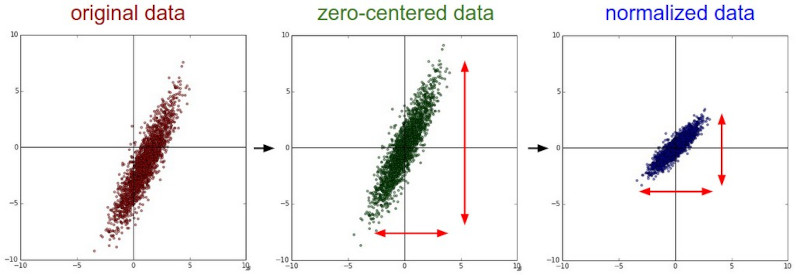

In [75]:
# сгенерируем модельные данные из равномерного распредления на отрезку [0, 20]

data = [
    (random.uniform(0, 20), )
    for i in range(20)
]

df = spark.createDataFrame(data, ['sales'])
df.show()

+-------------------+
|              sales|
+-------------------+
|  19.92328226050756|
|  3.304435906141101|
|  7.559342887070663|
| 17.051801711660964|
|0.14991307688056343|
|  5.628684740974366|
| 19.240635409209194|
|  15.47022307944307|
|  4.214729494734919|
| 16.934841427970756|
|  1.245806585594491|
|  7.423778421090459|
|  3.542387219286074|
| 1.3676561869355508|
| 1.4532083012886932|
|  5.726616630507541|
| 12.174672104536825|
|  19.48527207838241|
|   5.43955544238345|
| 14.751055801875449|
+-------------------+



In [76]:
def normalize(df, input_column, output_column):

    wspec = Window().partitionBy()

    df = df.withColumn("mu", F.mean(input_column).over(wspec))
    df = df.withColumn("sigma", F.sqrt(F.mean((F.col(input_column) - F.col("mu")) ** 2).over(wspec)))

    df = df.withColumn(output_column, (F.col(input_column) - F.col("mu")) / F.col("sigma"))

    return df

In [77]:
normalized_df = normalize(df, "sales", "normalized_sales")
normalized_df.show()

+-------------------+-----------------+-----------------+--------------------+
|              sales|               mu|            sigma|    normalized_sales|
+-------------------+-----------------+-----------------+--------------------+
|  19.92328226050756|9.104394938323704|6.800079028245288|  1.5909943512782367|
|  3.304435906141101|9.104394938323704|6.800079028245288| -0.8529252392643503|
|  7.559342887070663|9.104394938323704|6.800079028245288|-0.22721089634920474|
| 17.051801711660964|9.104394938323704|6.800079028245288|  1.1687227075341846|
|0.14991307688056343|9.104394938323704|6.800079028245288| -1.3168202640365168|
|  5.628684740974366|9.104394938323704|6.800079028245288| -0.5111279123246043|
| 19.240635409209194|9.104394938323704|6.800079028245288|  1.4906062751304634|
|  15.47022307944307|9.104394938323704|6.800079028245288|  0.9361403175871652|
|  4.214729494734919|9.104394938323704|6.800079028245288| -0.7190600908134634|
| 16.934841427970756|9.104394938323704|6.80007902824

In [78]:
# посмотрим чему теперь равны среднее и стандартное отклонение для нормализоавнного датафрейма
normalize(normalized_df, "normalized_sales", "tmp").show(20, False)

+-------------------+----------------------+-----+--------------------+--------------------+
|sales              |mu                    |sigma|normalized_sales    |tmp                 |
+-------------------+----------------------+-----+--------------------+--------------------+
|19.92328226050756  |1.2212453270876723E-16|1.0  |1.5909943512782367  |1.5909943512782365  |
|3.304435906141101  |1.2212453270876723E-16|1.0  |-0.8529252392643503 |-0.8529252392643504 |
|7.559342887070663  |1.2212453270876723E-16|1.0  |-0.22721089634920474|-0.22721089634920486|
|17.051801711660964 |1.2212453270876723E-16|1.0  |1.1687227075341846  |1.1687227075341844  |
|0.14991307688056343|1.2212453270876723E-16|1.0  |-1.3168202640365168 |-1.316820264036517  |
|5.628684740974366  |1.2212453270876723E-16|1.0  |-0.5111279123246043 |-0.5111279123246044 |
|19.240635409209194 |1.2212453270876723E-16|1.0  |1.4906062751304634  |1.4906062751304632  |
|15.47022307944307  |1.2212453270876723E-16|1.0  |0.9361403175871652  

##### `MinMax Scaler`

Если необходимо преобразовать данные к заранее заданному интервалу, например, к единичному интервалу [0, 1], то тут подойдёт min-max нормализация.

$$X = \frac{X - min(X)}{max(X) - min(X)}$$

In [79]:
def min_max_normalize(df, input_column, output_column):

    wspec = Window().partitionBy()

    df = df.withColumn("max", F.max(input_column).over(wspec))
    df = df.withColumn("min", F.min(input_column).over(wspec))

    df = df.withColumn(output_column, (F.col(input_column) - F.col("min")) / (F.col("max") - F.col("min")))

    return df

In [80]:
normalized_df = min_max_normalize(df, "sales", "normalized_sales")
normalized_df.show()

+-------------------+-----------------+-------------------+-------------------+
|              sales|              max|                min|   normalized_sales|
+-------------------+-----------------+-------------------+-------------------+
|  19.92328226050756|19.92328226050756|0.14991307688056343|                1.0|
|  3.304435906141101|19.92328226050756|0.14991307688056343|0.15953390643576243|
|  7.559342887070663|19.92328226050756|0.14991307688056343| 0.3747176184989937|
| 17.051801711660964|19.92328226050756|0.14991307688056343| 0.8547804108556131|
|0.14991307688056343|19.92328226050756|0.14991307688056343|                0.0|
|  5.628684740974366|19.92328226050756|0.14991307688056343|0.27707830735443945|
| 19.240635409209194|19.92328226050756|0.14991307688056343| 0.9654764524467778|
|  15.47022307944307|19.92328226050756|0.14991307688056343| 0.7747951226869434|
|  4.214729494734919|19.92328226050756|0.14991307688056343| 0.2055702485553225|
| 16.934841427970756|19.92328226050756|0

### `Примеры`

In [81]:
from pyspark.sql import SparkSession
from pyspark.sql.functions import col, rand
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.regression import LinearRegression
from pyspark.ml.classification import LogisticRegression
from pyspark.ml.evaluation import RegressionEvaluator, BinaryClassificationEvaluator
from pyspark.ml.tuning import ParamGridBuilder, CrossValidator
from pyspark.ml import Pipeline

# Инициализация Spark-сессии
spark = SparkSession.builder.appName("PySpark ML Examples").getOrCreate()

##### `Регрессия (Linear Regression)`

1. Создаем синтетические данные.
2. Генерируем признаки.
3. Обучаем линейную регрессию.
4. Оцениваем модель.
5. Оптимизируем гиперпараметры.

In [82]:
# Генерация данных:
# Создаем DataFrame с 1000 строками, добавляя три колонки:
# feature1 - случайное число от 0 до 10
# feature2 - случайное число от 0 до 5
# label - случайное число от 0 до 50 (целевая переменная, которую мы будем предсказывать)
train_data = (spark.range(0, 1000)
              .withColumn("feature1", rand() * 10)
              .withColumn("feature2", rand() * 5)
              .withColumn("label", rand() * 50))
train_data.show()

+---+------------------+-------------------+------------------+
| id|          feature1|           feature2|             label|
+---+------------------+-------------------+------------------+
|  0|1.6395959124767467|  3.054665021439785|12.735118246706605|
|  1| 8.630980293936027| 0.6855174358605687|30.106686095193762|
|  2| 2.710748678275544|  1.840736889461283| 32.22994976596439|
|  3| 6.812625353655575| 0.9793239810790066| 46.18628303965329|
|  4|3.7786562697635926| 2.5065846064038446| 42.65388191448488|
|  5| 7.408037591594421| 0.3987932656175025| 20.85258941974029|
|  6|  5.41087781072336|   2.09125641023998|31.498750518718886|
|  7|3.7017378363271636|  0.995971516532605| 37.97234929528976|
|  8| 6.289663878688766|  4.375939346909618| 9.309334102552736|
|  9|  8.23013519414074| 2.3620372246395958| 18.07149284707404|
| 10| 5.266784385648073|  4.924125049936878|30.073667609604403|
| 11|2.1457436654333986|0.07581133703631282|16.530903925610552|
| 12| 6.477719833794379| 2.5094728816930

VectorAssembler – https://spark.apache.org/docs/latest/api/python/reference/api/pyspark.ml.feature.VectorAssembler.html

In [83]:
# Подготовка признаков:
# VectorAssembler объединяет несколько числовых колонок в один вектор признаков,
# так как алгоритмы MLlib требуют входные данные в виде вектора
assembler = VectorAssembler(inputCols=["feature1", "feature2"], outputCol="features")
train_data = assembler.transform(train_data)

In [85]:
train_data.printSchema()

root
 |-- id: long (nullable = false)
 |-- feature1: double (nullable = false)
 |-- feature2: double (nullable = false)
 |-- label: double (nullable = false)
 |-- features: vector (nullable = true)



In [84]:
train_data.show(truncate=False)

+---+------------------+-------------------+------------------+----------------------------------------+
|id |feature1          |feature2           |label             |features                                |
+---+------------------+-------------------+------------------+----------------------------------------+
|0  |1.6395959124767467|3.054665021439785  |12.735118246706605|[1.6395959124767467,3.054665021439785]  |
|1  |8.630980293936027 |0.6855174358605687 |30.106686095193762|[8.630980293936027,0.6855174358605687]  |
|2  |2.710748678275544 |1.840736889461283  |32.22994976596439 |[2.710748678275544,1.840736889461283]   |
|3  |6.812625353655575 |0.9793239810790066 |46.18628303965329 |[6.812625353655575,0.9793239810790066]  |
|4  |3.7786562697635926|2.5065846064038446 |42.65388191448488 |[3.7786562697635926,2.5065846064038446] |
|5  |7.408037591594421 |0.3987932656175025 |20.85258941974029 |[7.408037591594421,0.3987932656175025]  |
|6  |5.41087781072336  |2.09125641023998   |31.49875051

LinearRegression – https://spark.apache.org/docs/latest/api/python/reference/api/pyspark.ml.regression.LinearRegression.html

In [86]:
# Обучение модели:
# LinearRegression - класс для обучения модели линейной регрессии
# featuresCol - указывает на колонку с вектором признаков
# labelCol - указывает на колонку с целевой переменной
lr = LinearRegression(featuresCol="features", labelCol="label")
model = lr.fit(train_data)

In [87]:
model

LinearRegressionModel: uid=LinearRegression_69a590e7a36d, numFeatures=2

In [88]:
# Оценка модели:
# Применяем обученную модель к данным, получая предсказания
predictions = model.transform(train_data)

In [89]:
predictions.printSchema()

root
 |-- id: long (nullable = false)
 |-- feature1: double (nullable = false)
 |-- feature2: double (nullable = false)
 |-- label: double (nullable = false)
 |-- features: vector (nullable = true)
 |-- prediction: double (nullable = false)



In [49]:
predictions.show()

+---+------------------+------------------+------------------+--------------------+------------------+
| id|          feature1|          feature2|             label|            features|        prediction|
+---+------------------+------------------+------------------+--------------------+------------------+
|  0| 6.873664051901733| 4.839265790530873|21.070137515426207|[6.87366405190173...|25.377383833260676|
|  1|0.5188141453540884|1.3831468787577612| 6.296710906812375|[0.51881414535408...| 25.23020293516294|
|  2|3.8517096381665636| 1.230858097163191|39.922032307497254|[3.85170963816656...|24.861974763406106|
|  3| 7.074824314728506|0.6347546383466857| 40.31852569936517|[7.07482431472850...|  24.4041309925311|
|  4| 4.785975359997315| 4.849063733431737|22.820575536608185|[4.78597535999731...| 25.58863473286921|
|  5| 5.635819137179569|  3.05733968647617|16.422880482890793|[5.63581913717956...| 25.09738202228138|
|  6|1.7592251251974567| 4.952998890249168| 25.68881139822642|[1.75922512

RegressionEvaluator – https://spark.apache.org/docs/latest/api/python/reference/api/pyspark.ml.evaluation.RegressionEvaluator.html

In [90]:
# RegressionEvaluator используется для оценки качества модели
# metricName="rmse" - используем RMSE (среднеквадратичную ошибку) как метрику качества
# RMSE показывает среднее отклонение предсказанных значений от реальных
# Чем ниже RMSE, тем лучше модель

# Инициализируем оценщик
evaluator = RegressionEvaluator(labelCol="label", predictionCol="prediction", metricName="rmse")
rmse = evaluator.evaluate(predictions)
print(f"RMSE модели: {rmse}")

RMSE модели: 14.351820657493505


ParamGridBuilder – https://spark.apache.org/docs/latest/api/python/reference/api/pyspark.ml.tuning.ParamGridBuilder.html

In [91]:
# Оптимизация модели:
# ParamGridBuilder позволяет создать сетку параметров для поиска наилучших значений
# lr.regParam - параметр регуляризации, уменьшающий переобучение модели
# Мы тестируем три значения: 0.1, 0.01, 0.001
paramGrid = ParamGridBuilder().addGrid(lr.regParam, [0.1, 0.01, 0.001]).build()

CrossValidator – https://spark.apache.org/docs/latest/api/python/reference/api/pyspark.ml.tuning.CrossValidator.html

In [92]:
# CrossValidator выполняет кросс-валидацию модели
# numFolds=3 - разделяем данные на 3 фолда для кросс-валидации
# estimator=lr - указываем, что тестируем модель линейной регрессии
# evaluator=evaluator - оцениваем по RMSE
crossval = CrossValidator(estimator=lr, estimatorParamMaps=paramGrid, evaluator=evaluator, numFolds=3)

In [93]:
# Обучаем модель с кросс-валидацией и выбираем лучшую
best_model = crossval.fit(train_data).bestModel
print(f"Лучший параметр regParam: {best_model._java_obj.getRegParam()}")

Лучший параметр regParam: 0.1


In [94]:
best_predictions = best_model.transform(train_data)
best_predictions.show()

+---+------------------+-------------------+------------------+--------------------+------------------+
| id|          feature1|           feature2|             label|            features|        prediction|
+---+------------------+-------------------+------------------+--------------------+------------------+
|  0|1.6395959124767467|  3.054665021439785|12.735118246706605|[1.63959591247674...|24.733959624423672|
|  1| 8.630980293936027| 0.6855174358605687|30.106686095193762|[8.63098029393602...| 25.34981201526082|
|  2| 2.710748678275544|  1.840736889461283| 32.22994976596439|[2.71074867827554...|24.970124747736932|
|  3| 6.812625353655575| 0.9793239810790066| 46.18628303965329|[6.81262535365557...|25.243361253074088|
|  4|3.7786562697635926| 2.5065846064038446| 42.65388191448488|[3.77865626976359...|24.892924170267236|
|  5| 7.408037591594421| 0.3987932656175025| 20.85258941974029|[7.40803759159442...|25.358930457112233|
|  6|  5.41087781072336|   2.09125641023998|31.498750518718886|[

In [95]:
# Логистическая регрессия

# Генерация данных для бинарной классификации
train_data_cls = spark.range(0, 1000).withColumn("feature1", rand() * 10).withColumn("feature2", rand() * 5)
train_data_cls = train_data_cls.withColumn("label", (train_data_cls.feature1 + train_data_cls.feature2 > 7).cast("int"))

In [97]:
train_data_cls.printSchema()

root
 |-- id: long (nullable = false)
 |-- feature1: double (nullable = false)
 |-- feature2: double (nullable = false)
 |-- label: integer (nullable = false)



In [98]:
train_data_cls.show()

+---+-------------------+-------------------+-----+
| id|           feature1|           feature2|label|
+---+-------------------+-------------------+-----+
|  0|  8.044749256523454|  4.610661011136084|    1|
|  1|  5.047726806320655| 2.7253687085764096|    1|
|  2|  5.172066724935034| 4.4717323105560265|    1|
|  3|  7.125400051212175| 4.8624235142608105|    1|
|  4| 1.0304013613850915| 2.7677381605940803|    0|
|  5|  4.544729854108217|  4.927826432124594|    1|
|  6|0.20317810374506862|  4.463131941790074|    0|
|  7|  6.873879468683023|  3.967781128318957|    1|
|  8| 3.3873902762237584|  4.494147080578727|    1|
|  9|0.29417345926897265|0.11133709250095325|    0|
| 10|  4.134960027769527| 0.4302241088891101|    0|
| 11| 0.5732435138249659| 2.1900434392277752|    0|
| 12|  4.166241358412563| 0.5847079845324954|    0|
| 13|  5.505580074644753| 2.6987392869169105|    1|
| 14|  4.136564805114666|  3.857255868683893|    1|
| 15|  2.552116819091924| 3.2009504001360196|    0|
| 16|0.10235

In [99]:
# Подготовка признаков
assembler_cls = VectorAssembler(inputCols=["feature1", "feature2"], outputCol="features")
train_data_cls = assembler_cls.transform(train_data_cls)

In [102]:
train_data_cls.show(5, truncate=False)

+---+------------------+------------------+-----+---------------------------------------+
|id |feature1          |feature2          |label|features                               |
+---+------------------+------------------+-----+---------------------------------------+
|0  |8.044749256523454 |4.610661011136084 |1    |[8.044749256523454,4.610661011136084]  |
|1  |5.047726806320655 |2.7253687085764096|1    |[5.047726806320655,2.7253687085764096] |
|2  |5.172066724935034 |4.4717323105560265|1    |[5.172066724935034,4.4717323105560265] |
|3  |7.125400051212175 |4.8624235142608105|1    |[7.125400051212175,4.8624235142608105] |
|4  |1.0304013613850915|2.7677381605940803|0    |[1.0304013613850915,2.7677381605940803]|
+---+------------------+------------------+-----+---------------------------------------+
only showing top 5 rows



In [103]:
# Обучение модели
lr_cls = LogisticRegression(featuresCol="features", labelCol="label")
model_cls = lr_cls.fit(train_data_cls)

In [104]:
# Оценка
predictions_cls = model_cls.transform(train_data_cls)
evaluator_cls = BinaryClassificationEvaluator(labelCol="label")
auc = evaluator_cls.evaluate(predictions_cls)
print(f"AUC модели: {auc}")

AUC модели: 1.0


In [105]:
# Потоковые данные

from pyspark.sql.types import StructType, StructField, DoubleType
from pyspark.sql.functions import expr

# Определяем схему входных данных
schema = StructType([
    StructField("feature1", DoubleType(), True),
    StructField("feature2", DoubleType(), True)
])

# Создаем потоковый источник данных (имитация стриминга)
streaming_data = (spark.readStream.format("rate").option("rowsPerSecond", 1).load()
                  .withColumn("feature1", rand() * 10)
                  .withColumn("feature2", rand() * 5)
                  .select("feature1", "feature2"))

# Применяем ту же подготовку признаков
streaming_data = assembler_cls.transform(streaming_data)

# Применяем обученную модель
predictions_stream = model_cls.transform(streaming_data)

# Выводим результаты в консоль (для демонстрации)
query = predictions_stream.select("feature1", "feature2", "prediction").writeStream.outputMode("append").format("console").start()

query.awaitTermination()

ERROR:root:KeyboardInterrupt while sending command.
Traceback (most recent call last):
  File "/usr/local/lib/python3.11/dist-packages/py4j/java_gateway.py", line 1038, in send_command
    response = connection.send_command(command)
               ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/py4j/clientserver.py", line 511, in send_command
    answer = smart_decode(self.stream.readline()[:-1])
                          ^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/lib/python3.11/socket.py", line 718, in readinto
    return self._sock.recv_into(b)
           ^^^^^^^^^^^^^^^^^^^^^^^
KeyboardInterrupt


KeyboardInterrupt: 